<a href="https://colab.research.google.com/github/andysingal/deep-learning/blob/main/Tensorflow_basics/Loading_and_Preprocessing_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Loading and Preprocessing Data with TensorFlow

when training TensorFlow models on large datasets, you may prefer to use TensorFlow’s own data loading and preprocessing API, called tf.data. It is capable of loading and preprocessing data extremely efficiently, reading from multiple files in parallel using multithreading and queuing, shuffling and batching samples, and more. Plus, it can do all of this on the fly—it loads and preprocesses the next batch of data across multiple CPU cores, while your GPUs or TPUs are busy training the current batch of data.

The tf.data API lets you handle datasets that don’t fit in memory, and it allows you to make full use of your hardware resources, thereby speeding up training. Off the shelf, the tf.data API can read from text files (such as CSV files), binary files with fixed-size records, and binary files that use TensorFlow’s TFRecord format, which supports records of varying sizes.

TFRecord is a flexible and efficient binary format usually containing protocol buffers (an open source binary format). The tf.data API also has support for reading from SQL databases. Moreover, many open source extensions are available to read from all sorts of data sources

In [22]:
import tensorflow.keras.backend as K
import numpy as np
import os
import tensorflow as tf
import pandas as pd
import random
from sklearn.decomposition import PCA

from tensorflow.keras import layers

from tqdm.notebook import trange
from collections import OrderedDict

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import requests

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

    
def fix_random_seed(seed):
    """ Setting the random seed of various libraries """
    try:
        np.random.seed(seed)
    except NameError:
        print("Warning: Numpy is not imported. Setting the seed for Numpy failed.")
    try:
        tf.random.set_seed(seed)
    except NameError:
        print("Warning: TensorFlow is not imported. Setting the seed for TensorFlow failed.")
    try:
        random.seed(seed)
    except NameError:
        print("Warning: random module is not imported. Setting the seed for random failed.")

# Fixing the random seed
fix_random_seed(4321)
print("TensorFlow version: {}".format(tf.__version__))

data_dir = '/content/data'
tf.keras.backend.clear_session()

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

TensorFlow version: 2.12.0


In [2]:
X = tf.range(10)  # any data tensor
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>

#Chaining Transformations

Once you have a dataset, you can apply all sorts of transformations to it by calling its transformation methods. 

In [3]:
dataset = tf.data.Dataset.from_tensor_slices(tf.range(10))
dataset = dataset.repeat(3).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


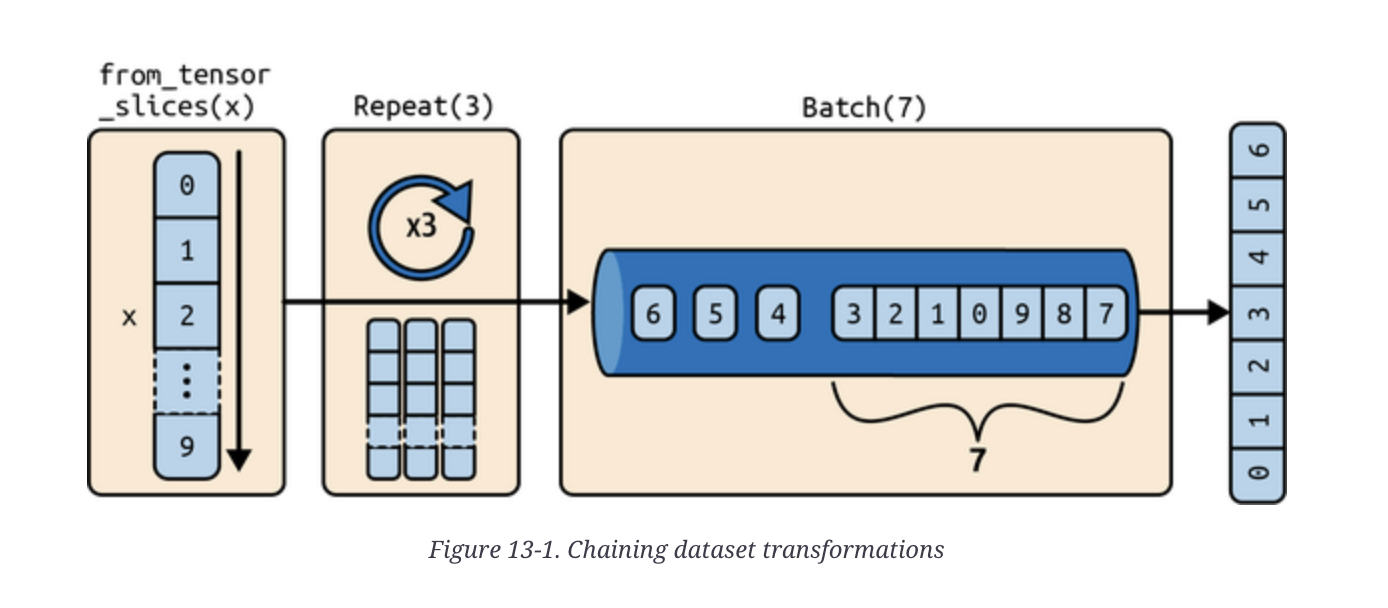

In [4]:
dataset = dataset.map(lambda x: x * 2)  # x is a batch
for item in dataset:
    print(item)

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int32)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)
tf.Tensor([16 18], shape=(2,), dtype=int32)


In [5]:
dataset = dataset.filter(lambda x: tf.reduce_sum(x) > 50)
for item in dataset:
    print(item)

tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)


# Shuffling the Data

In [6]:
dataset = tf.data.Dataset.range(10).repeat(2)
dataset = dataset.shuffle(buffer_size=4, seed=42).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 3 2 5 7 4 6], shape=(7,), dtype=int64)
tf.Tensor([9 8 1 1 3 2 0], shape=(7,), dtype=int64)
tf.Tensor([6 5 8 4 9 7], shape=(6,), dtype=int64)


If you call repeat() on a shuffled dataset, by default it will generate a new order at every iteration. This is generally a good idea, but if you prefer to reuse the same order at each iteration (e.g., for tests or debugging), you can set reshuffle_each_​itera⁠tion=False when calling shuffle().

#Interleaving Lines from Multiple Files
First, suppose you’ve loaded the California housing dataset, shuffled it (unless it was already shuffled), and split it into a training set, a validation set, and a test set. Then you split each set into many CSV files that each look like this (each row contains eight input features plus the target median house value):

In [7]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

In [8]:
# extra code – split the dataset into 20 parts and save it to CSV files

import numpy as np
from pathlib import Path

def save_to_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = Path() / "datasets" / "housing"
    housing_dir.mkdir(parents=True, exist_ok=True)
    filename_format = "my_{}_{:02d}.csv"

    filepaths = []
    m = len(data)
    chunks = np.array_split(np.arange(m), n_parts)
    for file_idx, row_indices in enumerate(chunks):
        part_csv = housing_dir / filename_format.format(name_prefix, file_idx)
        filepaths.append(str(part_csv))
        with open(part_csv, "w") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_csv_files(test_data, "test", header, n_parts=10)

In [9]:
print("".join(open(train_filepaths[0]).readlines()[:4]))

MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442
5.3275,5.0,6.490059642147117,0.9910536779324056,3464.0,3.4433399602385686,33.69,-117.39,1.687
3.1,29.0,7.5423728813559325,1.5915254237288134,1328.0,2.2508474576271187,38.44,-122.98,1.621



In [10]:
train_filepaths

['datasets/housing/my_train_00.csv',
 'datasets/housing/my_train_01.csv',
 'datasets/housing/my_train_02.csv',
 'datasets/housing/my_train_03.csv',
 'datasets/housing/my_train_04.csv',
 'datasets/housing/my_train_05.csv',
 'datasets/housing/my_train_06.csv',
 'datasets/housing/my_train_07.csv',
 'datasets/housing/my_train_08.csv',
 'datasets/housing/my_train_09.csv',
 'datasets/housing/my_train_10.csv',
 'datasets/housing/my_train_11.csv',
 'datasets/housing/my_train_12.csv',
 'datasets/housing/my_train_13.csv',
 'datasets/housing/my_train_14.csv',
 'datasets/housing/my_train_15.csv',
 'datasets/housing/my_train_16.csv',
 'datasets/housing/my_train_17.csv',
 'datasets/housing/my_train_18.csv',
 'datasets/housing/my_train_19.csv']

#Building an Input Pipeline

In [11]:
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)

In [12]:
for filepath in filepath_dataset:
    print(filepath)

tf.Tensor(b'datasets/housing/my_train_04.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_12.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_01.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_00.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_07.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_13.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_10.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_17.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_08.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_19.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_09.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_14.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_16.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_11.csv', shape=(), dtype=string)
tf.Ten

In [13]:
n_readers = 5
dataset = filepath_dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
    cycle_length=n_readers)

The interleave() method will create a dataset that will pull five filepaths from the filepath_dataset, and for each one it will call the function you gave it (a lambda in this example) to create a new dataset (in this case a TextLineDataset). To be clear, at this stage there will be seven datasets in all: the filepath dataset, the interleave dataset, and the five TextLineDatasets created internally by the interleave dataset. When you iterate over the interleave dataset, it will cycle through these five TextLineDatasets, reading one line at a time from each until all datasets are out of items. Then it will fetch the next five filepaths from the filepath_dataset and interleave them the same way, and so on until it runs out of filepaths. For interleaving to work best, it is preferable to have files of identical length; otherwise the end of the longest file will not be interleaved.

By default, interleave() does not use parallelism; it just reads one line at a time from each file, sequentially. If you want it to actually read files in parallel, you can set the interleave() method’s num_parallel_calls argument to the number of threads you want (recall that the map() method also has this argument). You can even set it to tf.data.AUTOTUNE to make TensorFlow choose the right number of threads dynamically based on the available CPU. Let’s look at what the dataset contains now:

In [14]:
for line in dataset.take(5):
    print(line)

tf.Tensor(b'4.7361,7.0,7.464968152866242,1.1178343949044587,846.0,2.694267515923567,34.49,-117.27,1.745', shape=(), dtype=string)
tf.Tensor(b'4.6477,38.0,5.03728813559322,0.911864406779661,745.0,2.5254237288135593,32.64,-117.07,1.504', shape=(), dtype=string)
tf.Tensor(b'2.4792,24.0,3.4547038327526134,1.1341463414634145,2251.0,3.921602787456446,34.18,-118.38,2.0', shape=(), dtype=string)
tf.Tensor(b'4.2708,45.0,5.121387283236994,0.953757225433526,492.0,2.8439306358381504,37.48,-122.19,2.67', shape=(), dtype=string)
tf.Tensor(b'3.6875,44.0,4.524475524475524,0.993006993006993,457.0,3.195804195804196,34.04,-118.15,1.625', shape=(), dtype=string)


#Preprocessing the Data
Now that we have a housing dataset that returns each instance as a tensor containing a byte string, we need to do a bit of preprocessing, including parsing the strings and scaling the data.

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)


X_mean, X_std = scaler.mean_, scaler.scale_  # extra code
n_inputs = 8

def parse_csv_line(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    return tf.stack(fields[:-1]), tf.stack(fields[-1:])

def preprocess(line):
    x, y = parse_csv_line(line)
    return (x - X_mean) / X_std, y

Let’s walk through this code:

- First, the code assumes that we have precomputed the mean and standard deviation of each feature in the training set. X_mean and X_std are just 1D tensors (or NumPy arrays) containing eight floats, one per input feature. This can be done using a Scikit-Learn StandardScaler on a large enough random sample of the dataset. Later in this chapter, we will use a Keras preprocessing layer instead.

- The parse_csv_line() function takes one CSV line and parses it. To help with that, it uses the tf.io.decode_csv() function, which takes two arguments: the first is the line to parse, and the second is an array containing the default value for each column in the CSV file. This array (defs) tells TensorFlow not only the default value for each column, but also the number of columns and their types. In this example, we tell it that all feature columns are floats and that missing values should default to zero, but we provide an empty array of type tf.float32 as the default value for the last column (the target): the array tells TensorFlow that this column contains floats, but that there is no default value, so it will raise an exception if it encounters a missing value.

- - The tf.io.decode_csv() function returns a list of scalar tensors (one per column), but we need to return a 1D tensor array. So we call tf.stack() on all tensors except for the last one (the target): this will stack these tensors into a 1D array. We then do the same for the target value: this makes it a 1D tensor array with a single value, rather than a scalar tensor. The tf.io.decode_csv() function is done, so it returns the input features and the target.

- Finally, the custom preprocess() function just calls the parse_csv_line() function, scales the input features by subtracting the feature means and then dividing by the feature standard deviations, and returns a tuple containing the scaled features and the target.

In [16]:
preprocess(b'4.2083,44.0,5.3232,0.9171,846.0,2.3370,37.47,-122.2,2.782')

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([ 0.16579159,  1.216324  , -0.05204564, -0.39215982, -0.5277444 ,
        -0.2633488 ,  0.8543046 , -1.3072058 ], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.782], dtype=float32)>)

#Putting Everything Together
To make the code more reusable, let’s put together everything we have discussed so far into another helper function; it will create and return a dataset that will efficiently load California housing data from multiple CSV files

In [17]:
def csv_reader_dataset(filepaths, n_readers=5, n_read_threads=None,
                       n_parse_threads=5, shuffle_buffer_size=10_000, seed=42,
                       batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths, seed=seed)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.shuffle(shuffle_buffer_size, seed=seed)
    return dataset.batch(batch_size).prefetch(1)

In [19]:
example_set = csv_reader_dataset(train_filepaths, batch_size=3)
for X_batch, y_batch in example_set.take(2):
    print("X =", X_batch)
    print("y =", y_batch)
    print()

X = tf.Tensor(
[[ 2.7180037e-01 -5.2405596e-01 -4.1212585e-02 -1.3690369e-01
   1.6342254e+00  6.5153203e-04  8.7304240e-01 -1.1872628e+00]
 [-9.7359484e-01  1.0880951e-01 -6.0779101e-01 -2.0596443e-01
  -1.0338144e-01 -2.0748030e-01 -8.9312232e-01  6.4688075e-01]
 [-9.5714879e-01 -1.1569214e+00 -4.6039385e-01 -5.0022248e-02
   2.2675757e+00 -1.3451891e-01  8.7304240e-01 -6.2752253e-01]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[2.235]
 [2.258]
 [1.065]], shape=(3, 1), dtype=float32)

X = tf.Tensor(
[[-0.9496591  -0.12851503  0.13091077  0.8669914  -0.9384183  -0.18488061
   0.994848   -1.2972121 ]
 [ 0.27871412 -0.998705   -0.21933386  0.11931785 -0.67102396 -0.41458014
   1.0557507  -1.467131  ]
 [ 0.8904651  -0.91959685  0.21106318 -0.07144897  0.6613846   0.06019508
   0.671598   -1.2072539 ]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[0.975]
 [2.671]
 [3.734]], shape=(3, 1), dtype=float32)



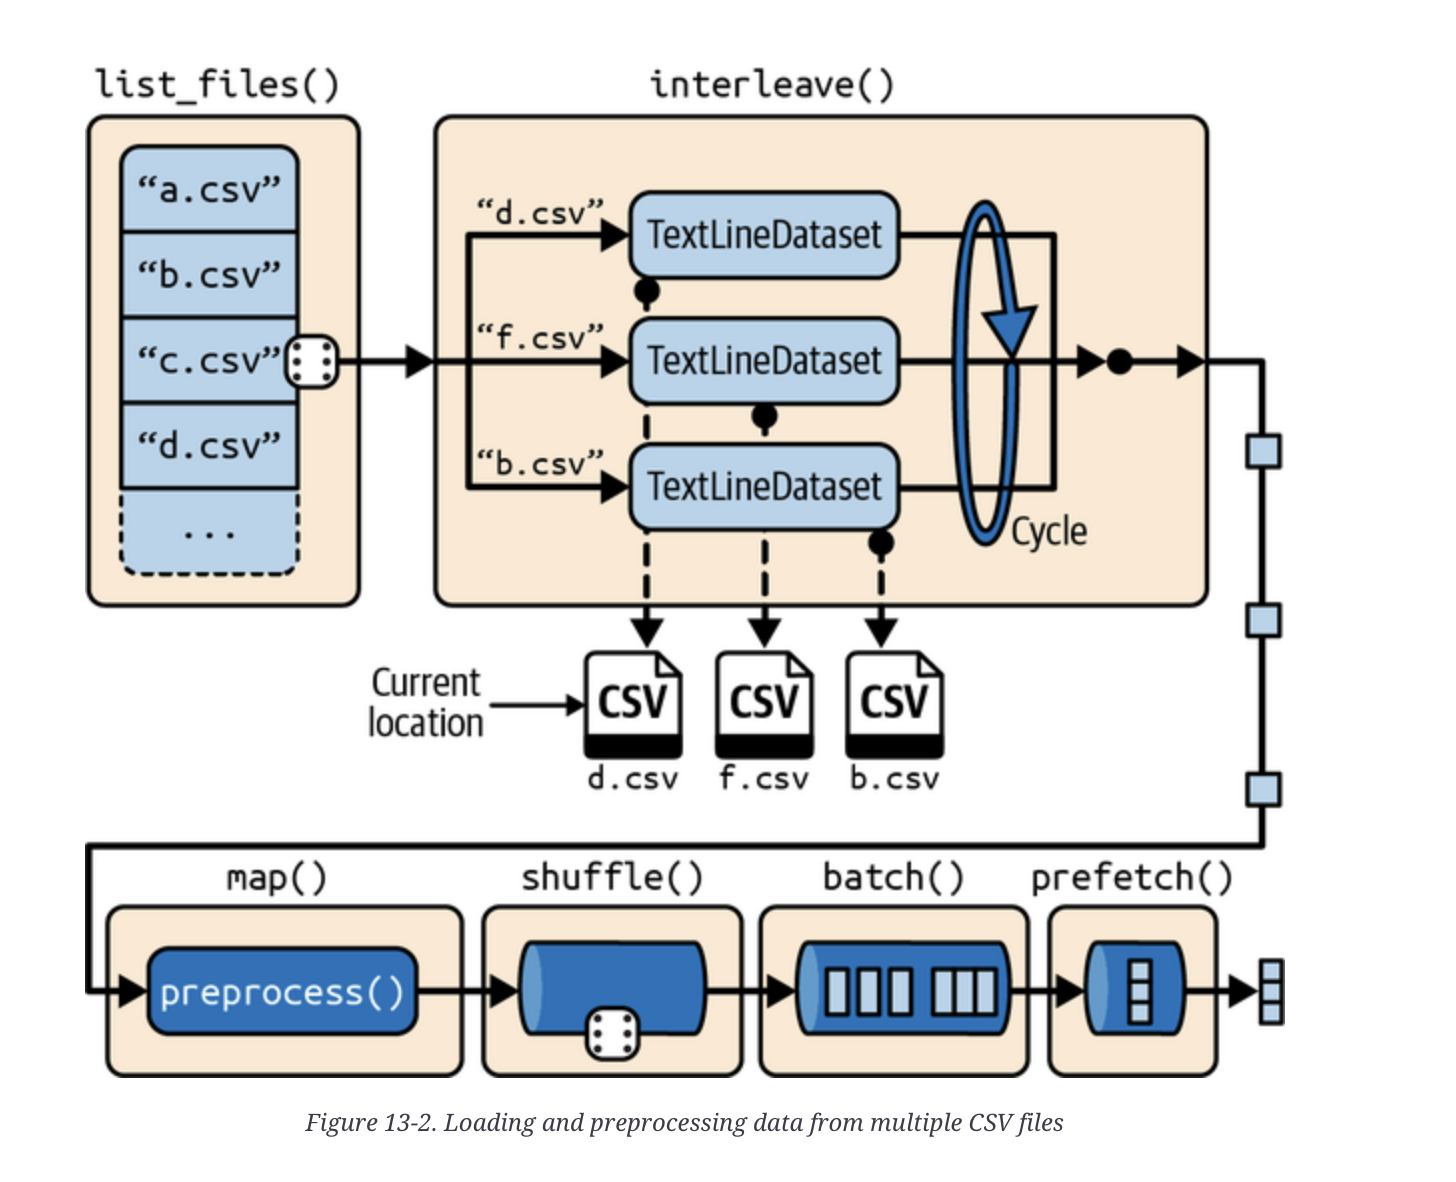

#Prefetching
By calling prefetch(1) at the end of the custom csv_reader_dataset() function, we are creating a dataset that will do its best to always be one batch ahead.⁠2 In other words, while our training algorithm is working on one batch, the dataset will already be working in parallel on getting the next batch ready (e.g., reading the data from disk and preprocessing it). This can improve performance dramatically

If we also ensure that loading and preprocessing are multithreaded (by setting num_parallel_calls when calling interleave() and map()), we can exploit multiple CPU cores and hopefully make preparing one batch of data shorter than running a training step on the GPU: this way the GPU will be almost 100% utilized (except for the data transfer time from the CPU to the GPU⁠3), and training will run much faster.

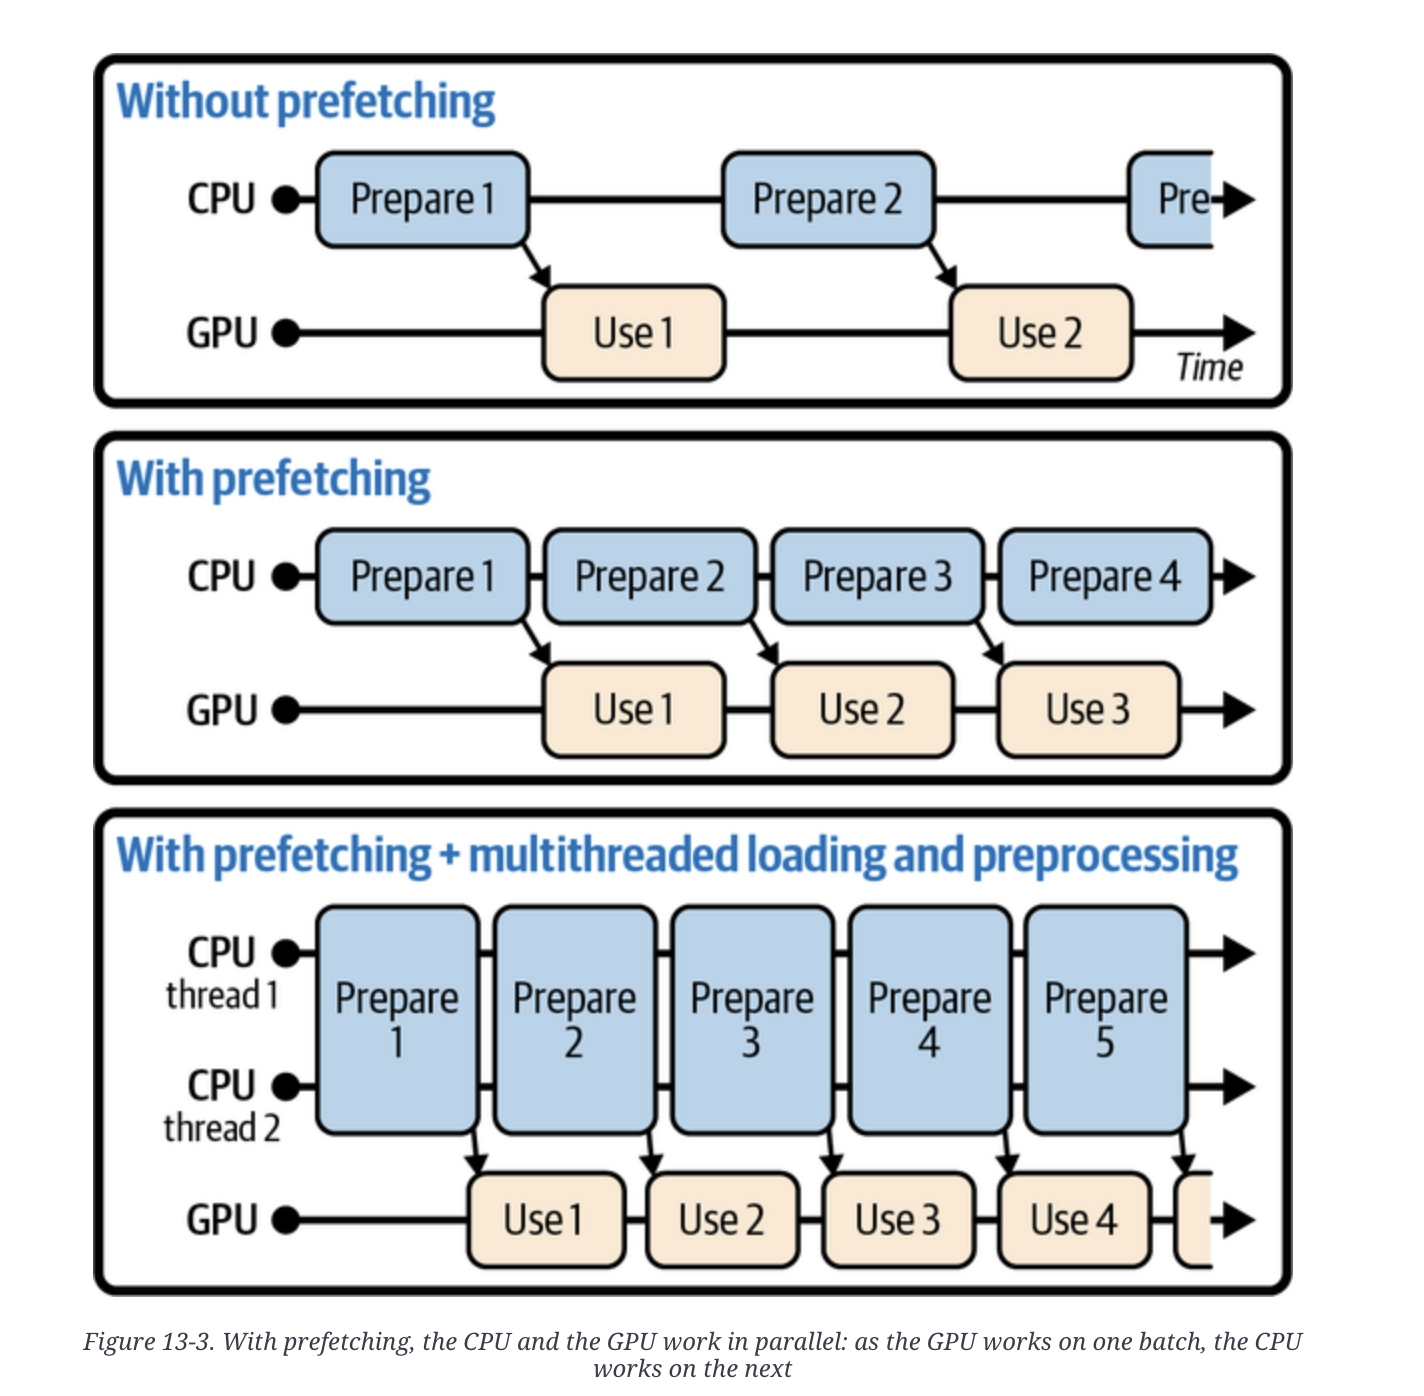

You have now learned how to build efficient input pipelines to load and preprocess data from multiple text files. We have discussed the most common dataset methods, but there are a few more you may want to look at, such as concatenate(), zip(), window(), reduce(), shard(), flat_map(), apply(), unbatch(), and padded_batch(). There are also a few more class methods, such as from_generator() and from_​ten⁠sors(), which create a new dataset from a Python generator or a list of tensors, respectively. Please check the API documentation for more details. Also note that there are experimental features available in tf.data.experimental, many of which will likely make it to the core API in future releases (e.g., check out the CsvDataset class, as well as the make_csv_dataset() method, which takes care of inferring the type of each column).

In [20]:
for m in dir(tf.data.Dataset):
    if not (m.startswith("_") or m.endswith("_")):
        func = getattr(tf.data.Dataset, m)
        if hasattr(func, "__doc__"):
            print("● {:21s}{}".format(m + "()", func.__doc__.split("\n")[0]))

● apply()              Applies a transformation function to this dataset.
● as_numpy_iterator()  Returns an iterator which converts all elements of the dataset to numpy.
● batch()              Combines consecutive elements of this dataset into batches.
● bucket_by_sequence_length()A transformation that buckets elements in a `Dataset` by length.
● cache()              Caches the elements in this dataset.
● cardinality()        Returns the cardinality of the dataset, if known.
● choose_from_datasets()Creates a dataset that deterministically chooses elements from `datasets`.
● concatenate()        Creates a `Dataset` by concatenating the given dataset with this dataset.
● counter()            Creates a `Dataset` that counts from `start` in steps of size `step`.
● element_spec()       The type specification of an element of this dataset.
● enumerate()          Enumerates the elements of this dataset.
● filter()             Filters this dataset according to `predicate`.
● flat_map()        

#Using the Dataset with Keras

In [21]:
train_set = csv_reader_dataset(train_filepaths)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(1),
])
model.compile(loss="mse", optimizer="sgd")
model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5
363/363 [==============================] - 6s 10ms/step - loss: 1.0775 - val_loss: 23.3521
Epoch 2/5
363/363 [==============================] - 2s 3ms/step - loss: 0.7623 - val_loss: 17.7860
Epoch 3/5
363/363 [==============================] - 1s 2ms/step - loss: 0.5904 - val_loss: 5.2007
Epoch 4/5
363/363 [==============================] - 1s 3ms/step - loss: 0.4795 - val_loss: 0.4349
Epoch 5/5
363/363 [==============================] - 2s 4ms/step - loss: 0.4174 - val_loss: 0.3884


In [24]:
test_mse = model.evaluate(test_set)
new_set = test_set.take(3)  # pretend we have 3 new samples
y_pred = model.predict(new_set)  # or you could just pass a NumPy array

3/3 [==============================] - 1s 22ms/step


In [26]:
n_epochs = 5
@tf.function
def train_one_epoch(model, optimizer, loss_fn, train_set):
    for X_batch, y_batch in train_set:
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.mean_squared_error
for epoch in range(n_epochs):
    print("\rEpoch {}/{}".format(epoch + 1, n_epochs), end="")
    train_one_epoch(model, optimizer, loss_fn, train_set)

Epoch 5/5

# The key features of TensorFlow


Dynamic computation graphs allow for interleaving the graph declaration and graph evaluation steps such that TensorFlow 2.0 feels much more natural for Python and NumPy users compared to previous versions of TensorFlow



In [27]:
a = tf.constant(1, name='a')
b = tf.constant(2, name='b')
c = tf.constant(3, name='c')

z = 2*(a - b) + c
tf.print('Result: z =', z)

Result: z = 1


#The TFRecord Format
The TFRecord format is TensorFlow’s preferred format for storing large amounts of data and reading it efficiently. It is a very simple binary format that just contains a sequence of binary records of varying sizes (each record is comprised of a length, a CRC checksum to check that the length was not corrupted

In [28]:
with tf.io.TFRecordWriter("my_data.tfrecord") as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

In [29]:
filepaths = ["my_data.tfrecord"]
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


By default, a TFRecordDataset will read files one by one, but you can make it read multiple files in parallel and interleave their records by passing the constructor a list of filepaths and setting num_parallel_reads to a number greater than one. Alternatively, you could obtain the same result by using list_files() and interleave() as we did earlier to read multiple CSV files.

In [30]:
# extra code – shows how to read multiple files in parallel and interleave them

filepaths = ["my_test_{}.tfrecord".format(i) for i in range(5)]
for i, filepath in enumerate(filepaths):
    with tf.io.TFRecordWriter(filepath) as f:
        for j in range(3):
            f.write("File {} record {}".format(i, j).encode("utf-8"))

dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=3)
for item in dataset:
    print(item)

tf.Tensor(b'File 0 record 0', shape=(), dtype=string)
tf.Tensor(b'File 1 record 0', shape=(), dtype=string)
tf.Tensor(b'File 2 record 0', shape=(), dtype=string)
tf.Tensor(b'File 0 record 1', shape=(), dtype=string)
tf.Tensor(b'File 1 record 1', shape=(), dtype=string)
tf.Tensor(b'File 2 record 1', shape=(), dtype=string)
tf.Tensor(b'File 0 record 2', shape=(), dtype=string)
tf.Tensor(b'File 1 record 2', shape=(), dtype=string)
tf.Tensor(b'File 2 record 2', shape=(), dtype=string)
tf.Tensor(b'File 3 record 0', shape=(), dtype=string)
tf.Tensor(b'File 4 record 0', shape=(), dtype=string)
tf.Tensor(b'File 3 record 1', shape=(), dtype=string)
tf.Tensor(b'File 4 record 1', shape=(), dtype=string)
tf.Tensor(b'File 3 record 2', shape=(), dtype=string)
tf.Tensor(b'File 4 record 2', shape=(), dtype=string)


#Compressed TFRecord Files

In [31]:
options = tf.io.TFRecordOptions(compression_type="GZIP")
with tf.io.TFRecordWriter("my_compressed.tfrecord", options) as f:
    f.write(b"Compress, compress, compress!")

In [32]:
dataset = tf.data.TFRecordDataset(["my_compressed.tfrecord"],
                                  compression_type="GZIP")

In [33]:
# extra code – shows that the data is decompressed correctly
for item in dataset:
    print(item)

tf.Tensor(b'Compress, compress, compress!', shape=(), dtype=string)
